# Data preprocessing of the PCa dataset

**Warning: The data required to run this notebook is still being uploaded to Metabolights.**

This notebook contains the the code to extract a data matrix from the PCa dataset from (ADD DOI). The following steps are applied to data:

1. Feature detection and extraction (Detection of chromatographic peaks)
2. Creation of a feature table with descriptors for the features detected in each sample
3. Feature correspondence
4. Data matrix creation.
5. Fill missing values.

A data curation pipeline is applied to the raw data matrix:

1. Correction of time-dependent drift.
2. Blank correction.
3. Filter features based on QC samples repeatability using CV. Features with %CV greater than 10 % are removed.
4. Filter features based on detection rate on QC samples. Features not detected in all QC samples are removed.
5. Filter features based on linearity of response, using a serial dilution experiment. Features with Pearson's correlation with the dilution factor lower than 0.9 are removed.
6. Filter features based on experimental reproducibility. Features with %CV greater than 25 % on a set of process replicates of QC samples are removed.
7. Retention time filter. Features with Retention times lower than 60 s are removed.

After data curation, samples where the internal standard (IS) signal is outside the interval defined by three times the standard deviation of the IS +/- the mean of the IS are considered outliers and removed from the dataset.

The data is available in the Metabolights repository with the identifier MTBLS5659. In order to run this code the directory called `centroid-data` must be downloaded from the repository and copied into the `data` directory. 

In [7]:
import numpy as np
import pandas as pd
import tidyms as ms
import matplotlib.pyplot as plt
from utils import data_container_to_csv

## Load study data

In [8]:
assay = ms.Assay(
    assay_path="pca-untargeted",
    data_path="/mnt/d/pca-project-mzml/untargeted-assay/",
    sample_metadata="data/sample-metadata.csv"
)

## Feature detection and extraction

In [9]:
roi_params = {"tolerance": 0.015, "min_intensity": 250, "min_length": 8}
assay.detect_features(n_jobs=2, **roi_params)

All samples are processed already.


In [10]:
assay.extract_features(n_jobs=2, store_smoothed=True)

All samples are processed already.


In [11]:
assay.describe_features(
    n_jobs=2,
    filters={"snr": (5, None), "width": (4, 60)}
)

All samples are processed already.


In [12]:
assay.build_feature_table()

## Feature correspondence

In [13]:
assay.match_features(
    include_classes=["QC", "healthy", "cancer", "post-surgery", "benign"],
    mz_tolerance=0.01,
    rt_tolerance=5,
    min_fraction=0.25,
    max_deviation=3,
    verbose=True,
    n_jobs=2
)

## Data matrix creation

In [19]:
data = assay.make_data_matrix(
    merge_close_features=True,
    mz_merge=0.010,
    rt_merge=5.0
)

/mnt/d/Documents/projects/tidyms/tidyms/validation.py:120: UserWarning: Data matrix has NANs. These values should be imputed before further analysis
  warnings.warn("Data matrix has NANs. These values should be imputed "


In [ ]:
assay.fill_missing(
    mz_tolerance=0.035,
    n_deviations=1.0,
    estimate_not_found=True,
    n_jobs=2,
    verbose=True
)

Filling missing values in 728 samples


  0%|          | 0/728 [00:00<?, ?it/s]

In [10]:
# save raw data matrix
data_container_to_csv(data, "data/raw")
data.save("data/tidyms-pca-filled.pickle")

In [1]:
# add dilution data and sample mapping to DataContainer

def class_to_dil_factor(x):
    try:
        res = 1 / int(x)
    except ValueError:
        res = 1
    return res

data.dilution = data.classes.apply(class_to_dil_factor)


mapping = {
    "qc": ["QC"],
    "sample": ["healthy", "post-surgery", "cancer", "benign", "SRM", "1", "2", "4", "8", "16", "pQC"],
    "blank": ["solvent", "process blank"],
    "dqc": ["1", "2", "4", "8", "16"]
}
data.mapping = mapping
# data.set_plot_mode("seaborn")

NameError: name 'data' is not defined

In [16]:
data.plot.pca_scores(scaling="autoscaling", hue="type")

Figure(id='1003', ...)

In [17]:
# internal standard (lacosamide)
is_mz = 249.1249
is_rt = 3.85 * 60 
is_ft = data.select_features(is_mz, is_rt)[0]
data.plot.feature(is_ft, hue="type")

Figure(id='1131', ...)

## Data Curation

In [18]:
# time-dependent drift correction
data.preprocess.correct_batches(n_jobs=2, verbose=True)

0 samples and 0 features were removed


Correcting 6310 features in 23 batches:   0%|          | 0/145130 [00:00<?, ?it/s]

In [19]:
# save DataContainer with batch corrected data
data.save("data/tidyms-pca-filled-batch-corrected.pickle")

In [12]:
# creating a custom filter to remove features based on retention time
class RTFilter(ms.filter.Processor):
    
    def __init__(self, min_rt=None, max_rt=None, verbose=False):
        super(RTFilter, self).__init__("filter", "features", verbose=verbose)
        self.name = "RtFilter"
        if min_rt is None:
            min_rt = 0
        if max_rt is None:
            max_rt = np.inf
        self.params = {"min_rt": min_rt, "max_rt": max_rt}
        
    def func(self, dc):
        rt = dc.feature_metadata["rt"]
        min_rt = self.params["min_rt"]
        max_rt = self.params["max_rt"]
        invalid_rt = (rt < min_rt) | (rt > max_rt)
        rm_features = rt[invalid_rt].index
        return rm_features

## Data Curation pipeline

In [14]:
rtf = RTFilter(min_rt=60, verbose=True)
bf = ms.filter.BlankCorrector(mode="loq", factor=1, robust=True)
pf = ms.filter.PrevalenceFilter(lb=1, process_classes=["QC"])
vf = ms.filter.VariationFilter(robust=True, ub=0.1)
df = ms.filter.DilutionFilter(mode="ols", plim=0, min_corr=0.9)
vf_pqc = ms.filter.VariationFilter(process_classes=["pQC"], ub=0.3)
crm = ms.filter.ClassRemover(data.mapping["blank"] + data.mapping["dqc"])

In [15]:
pipeline = ms.filter.Pipeline([rtf, bf, pf, df, crm], verbose=True)
pipeline.process(data)

Applying RtFilter: 1030 features removed, 0 samples removed, Mean CV reduced by -1.37 %.
Applying Blank Corrector: 0 features removed, 0 samples removed, Mean CV reduced by 35.20 %.
Applying Prevalence Filter: 239 features removed, 0 samples removed, Mean CV reduced by -0.75 %.


/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

Applying Dilution Filter: 2498 features removed, 0 samples removed, Mean CV reduced by 7.71 %.
Applying Class Remover: 0 features removed, 107 samples removed, Mean CV reduced by -40.29 %.


In [16]:
data_container_to_csv(data, "data/curated-no-cv-filter")
data.save("data/tidyms-pca-filled-batch-corrected-pertial-curation-no-cv-filter.pickle")

In [17]:
pipeline = ms.filter.Pipeline([vf, vf_pqc], verbose=True)
pipeline.process(data)

Applying Variation Filter: 1811 features removed, 0 samples removed, Mean CV reduced by 2.33 %.
Applying Variation Filter: 213 features removed, 0 samples removed, Mean CV reduced by -0.45 %.


## Remove outliers based on Internal Standard CV

In [19]:
lacosamide_mz = 249.1249
lacosamide_rt = 3.85 * 60
lacosamide_ft = data.select_features(lacosamide_mz, lacosamide_rt)[0]

study_sample_mask = data.classes.isin(data.mapping["sample"])
lacosamide_mean = data.data_matrix.loc[study_sample_mask, lacosamide_ft].mean()
lacosamide_std = data.data_matrix.loc[study_sample_mask, lacosamide_ft].std()
n_std = 3
lacosamide_signal = data.data_matrix.loc[study_sample_mask, lacosamide_ft]
batches = data.batch[study_sample_mask]

outliers = lacosamide_signal.groupby(batches).apply(lambda x: ((x - x.mean()).abs() / x.std()) > n_std)
outliers = outliers[outliers].index

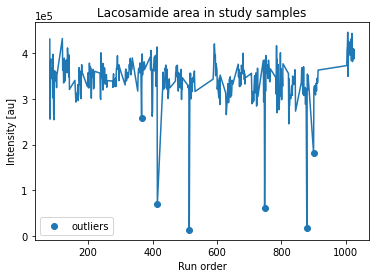

In [21]:
outlier_index = np.where(lacosamide_signal.index.isin(outliers))[0]
x = data.order[study_sample_mask].to_numpy()
y = lacosamide_signal.to_numpy()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter(x[outlier_index], y[outlier_index], label="outliers")
ax.set_xlabel("Run order")
ax.set_ylabel("Intensity [au]")
ax.set_title("Lacosamide area in study samples")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.legend()

In [22]:
data.remove(outliers, "samples")

In [23]:
data_container_to_csv(data, "data/curated")
data.save("data/tidyms-pca-curated.pickle")

In [24]:
data.plot.pca_scores(scaling="autoscaling")

Figure(id='1003', ...)